In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import sys
import pandas as pd
import os
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

## Prepare data

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'concrete_data.csv'))

In [3]:
X = data.drop('ccs', axis=1)
y = data['ccs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(825, 8) (102, 8) (103, 8)
(825,) (102,) (103,)


In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [5]:
def msse(pred, y):
    return (np.sum((y - pred)**2)) / y.shape[0]

In [6]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 90, 0.1), np.arange(0, 90, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [7]:
def normalize_weights(w, var, gamma):
    return w * gamma / np.sqrt(var + 0.0001)

In [8]:
def normalize_bias(b, mean, var, beta, gamma):
    return (b - mean) * (gamma / np.sqrt(var + 0.0001)) + beta

In [9]:
def relu(z):
    return np.maximum(0, z)

## Predictions

### Unencrypted

In [10]:
weights = np.load('relu_weights.npy')
w1, b1, gamma, beta, mean, var, w2, b2 = weights

In [11]:
w_norm = normalize_weights(w1, var, gamma)
b_norm = normalize_bias(b1, mean, var, beta, gamma).reshape(1, -1)

In [12]:
layer1_clear = X_test.dot(w_norm) + b_norm
print(layer1_clear.max())
layer1_clear = relu(layer1_clear)
pred_clear = layer1_clear.dot(w2) + b2

13.135468399435503


In [13]:
msse_clear = msse(pred_clear.flatten(), y_test)
print('MSSE relu clear: {}'.format(msse_clear))

MSSE relu clear: 46.83646093087816


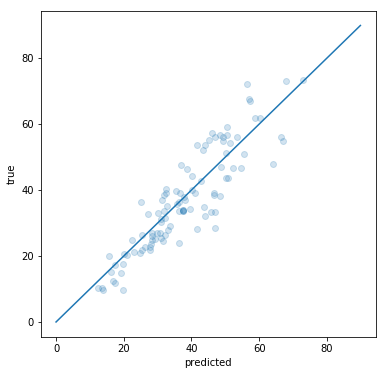

In [14]:
plot_predictions(pred_clear.flatten(), y_test)

### Encrypted

In [15]:
X_test_enc = EA(X_test, to_encrypt=True)

In [16]:
layer1_enc = X_test_enc.dot(EA(w_norm)) + EA(b_norm)
layer1_enc = layer1_enc.relu()
pred_enc = layer1_enc.dot(EA(w2)) + EA(b2.reshape(1, -1))

In [22]:
vals = np.delete(pred_enc.values(), 16)
ys = np.delete(y_test.values, 16)

In [23]:
msse_enc = msse(vals.flatten(), ys)
print('MSSE relu encrypted: {}'.format(msse_enc))

MSSE relu encrypted: 105.79885412132785


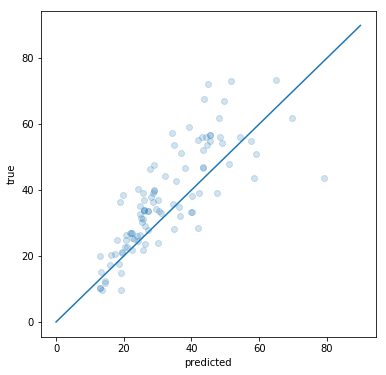

In [25]:
plot_predictions(vals, ys)